In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
seed = 27

# Loading Data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv', index_col='id')

In [3]:
train.describe()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [4]:
train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


# Preprocessing

In [5]:
train['Sex'] = train['Sex'].map({'M': 0, 'F': 1, 'I': 2})
test['Sex'] = test['Sex'].map({'M': 0, 'F': 1, 'I': 2})

numerical_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']

In [6]:
X = train.drop(columns='Rings')
y = train['Rings']

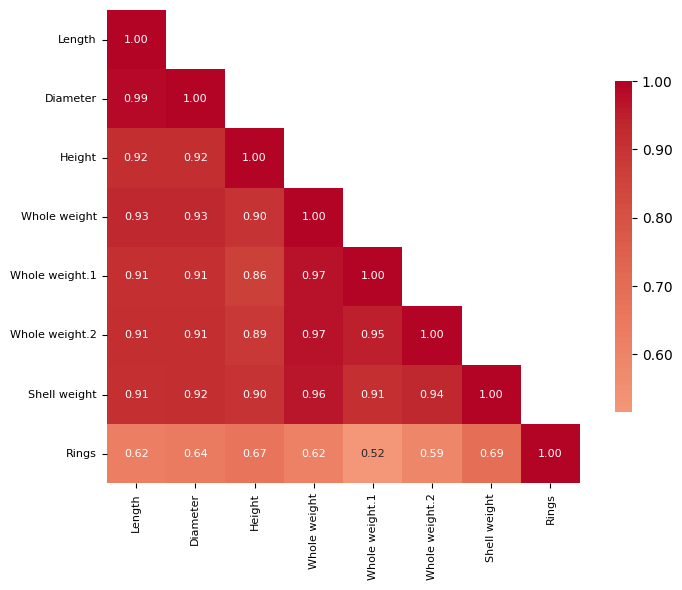

In [7]:
plt.figure(figsize=(8, 6))
corr = train[numerical_features + ["Rings"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(
    data=corr,
    annot=True,
    fmt='.2f',
    mask=mask,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={"size": 8},
    center=0
)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

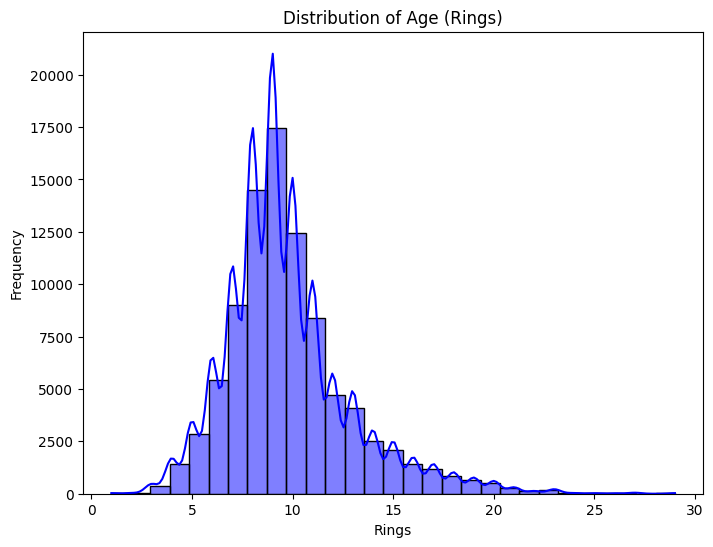

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(train['Rings'], bins=29, kde=True, color='blue')
plt.title('Distribution of Age (Rings)')
plt.xlabel('Rings')
plt.ylabel('Frequency')
plt.show()

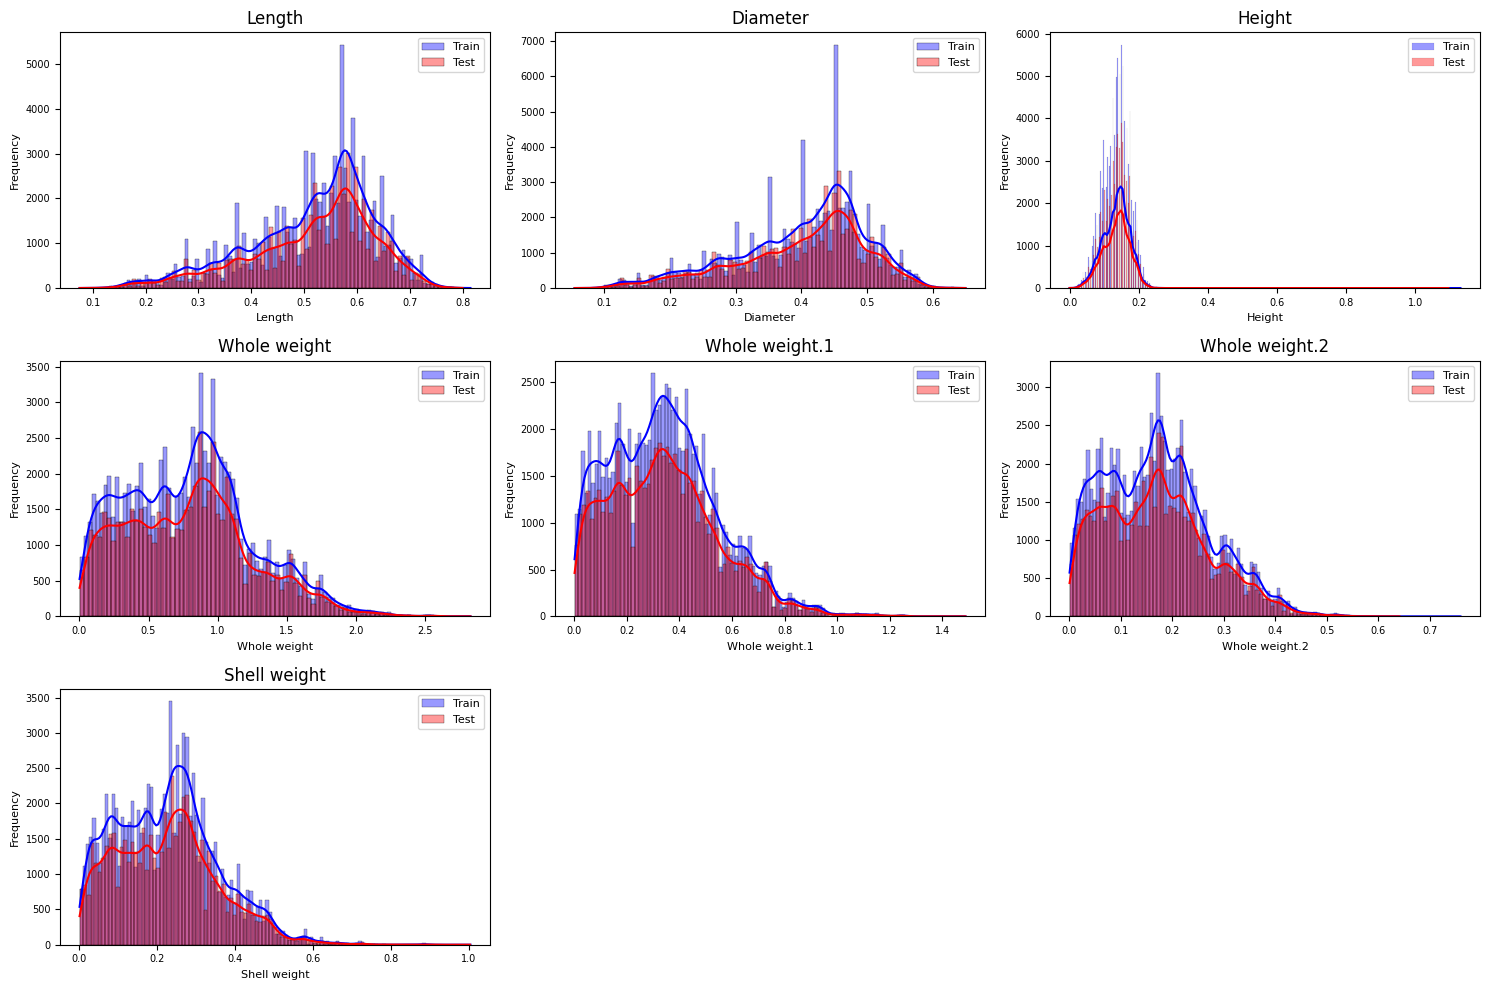

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features):   
    sns.histplot(train[col], kde=True, color='blue', ax=axes[i], alpha=0.4, label='Train')
    sns.histplot(test[col], kde=True, color='red', ax=axes[i], alpha=0.4, label='Test')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(f'{col}', fontsize=8)
    axes[i].set_ylabel('Frequency', fontsize=8)
    axes[i].legend(fontsize=8)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Training

In [10]:
def train(model, X, y, n_repeats):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    scores = []
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        y_pred = np.zeros_like(y_val, dtype=float)
        
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                m.regressor.set_params(random_state=i)
            m.fit(X_train, y_train)
            y_pred += m.predict(X_val)
            
        y_pred /= n_repeats
        y_pred = y_pred.clip(1, 29)
        
        score = mean_squared_log_error(y_val, y_pred, squared=False)
        print(f"Fold {fold_idx + 1} Score: {score:.5f}")
        scores.append(score)
    print(f"\nFinal Score: {np.array(scores).mean():.5f}")
    
def predict(model, X, y, X_test, n_repeats):
    y_pred = np.zeros(len(X_test), dtype=float)
    for i in range(n_repeats):
        m = clone(model)
        if n_repeats > 1:
            m.regressor.set_params(random_state=i)
        m.fit(X, y)
        y_pred += m.predict(X_test)
    y_pred /= n_repeats
    y_pred = y_pred.clip(1, 29)
    return y_pred

In [11]:
xgb_params = {
    'n_estimators': 898, 
    'learning_rate': 0.011752526484381335, 
    'gamma': 0.052364292997697987, 
    'reg_alpha': 0.6903156947513249, 
    'reg_lambda': 0.32322010942233625,
    'max_depth': 9, 
    'min_child_weight': 10, 
    'subsample': 0.5317519081449947, 
    'colsample_bytree': 0.6644765245752944,
}

model = TransformedTargetRegressor(
    regressor=XGBRegressor(**xgb_params),
    func=np.log1p,
    inverse_func=np.expm1
)

train(model, X, y, n_repeats=5)

Fold 1 Score: 0.14924
Fold 2 Score: 0.14927
Fold 3 Score: 0.14825
Fold 4 Score: 0.14879
Fold 5 Score: 0.14787

Final Score: 0.14868


# Making Predictions

In [12]:
predictions = predict(model, X, y, test, n_repeats=5)

In [13]:
submission = pd.DataFrame({'id': test.index, 'Rings': predictions})
submission.to_csv('XGBoost.csv', index=False)
submission.head()

,id,Rings
0,90615,9.877930
1,90616,9.738006
2,90617,10.007202
3,90618,10.298439
4,90619,7.568041


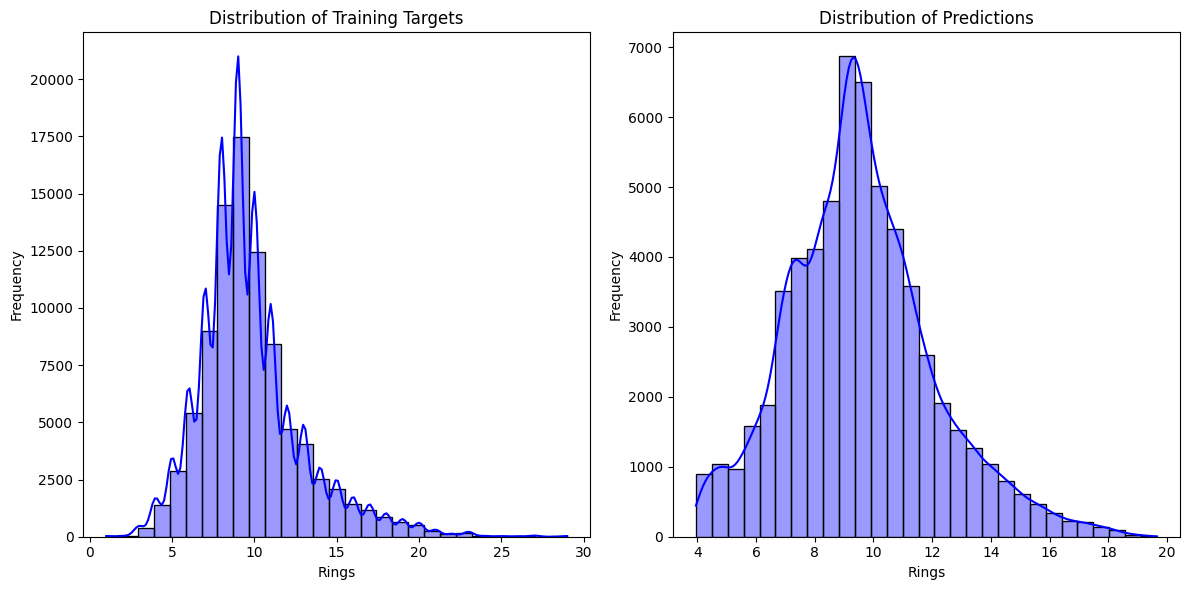

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(y, bins=29, kde=True, color='blue', alpha=0.4, label='Training Targets', ax=axes[0])
axes[0].set_title('Distribution of Training Targets')
axes[0].set_xlabel('Rings')
axes[0].set_ylabel('Frequency')

sns.histplot(predictions, bins=29, kde=True, color='blue', alpha=0.4, label='Predictions', ax=axes[1])
axes[1].set_title('Distribution of Predictions')
axes[1].set_xlabel('Rings')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()